## Задача

- [x] Найти или сгенерировать набор данных для бинарной классификации графов.
- [x] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [x] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [x] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

\\

---

### Генерация

Генерируем по 500 графов класса:

- граф планарный (его можно нарисовать на плоскости без пересечений рёбер)
- граф непланарный

Количество нод - от 10 до 20 включительно

In [117]:
import networkx as nx
import random
from sklearn.model_selection import train_test_split

SEED = 42

N_graphs = 500
N_nodes = list(range(10, 20 + 1))

def generate_planar_graph(n):
    # Дерево (всегда планарно)
    if random.random() < 0.5:
        G = nx.random_labeled_tree(n)
    # Планарный граф с циклами
    else:
        rows = int(n**0.5)
        cols = (n + rows - 1) // rows
        G = nx.grid_2d_graph(rows, cols)
        G = nx.convert_node_labels_to_integers(G)
        while G.number_of_nodes() > n:
            G.remove_node(G.number_of_nodes() - 1)
    return G

def generate_non_planar_graph(n):
    # Полный граф K5
    if n >= 5 and random.random() < 0.5:
        G = nx.complete_graph(5)
        for i in range(5, n):
            G.add_node(i)
            parent = random.choice(list(G.nodes())[:i])
            G.add_edge(i, parent)
    # Полный двудольный граф K3,3
    else:
        G = nx.complete_bipartite_graph(3, 3)
        for i in range(6, n):
            G.add_node(i)
            parent = random.choice(list(G.nodes())[:i])
            G.add_edge(i, parent)
    return G


def generate_data(n_samples=N_graphs):
    random.seed(SEED)
    graphs = []
    labels = []

    for _ in range(n_samples):
        label = random.choice([0, 1])
        n_nodes = random.choice(N_nodes)
        if label == 0:
            # Генерируем планарный граф
            G = generate_planar_graph(n_nodes)
            # G = nx.generators.trees.random_unlabeled_tree(n_nodes, seed=SEED)
        else:
            # Генерируем непланарный граф
            G = generate_non_planar_graph(n_nodes)
            # G = nx.cycle_graph(n_nodes)

        graphs.append(G)
        labels.append(label)

    return graphs, labels

# Генерация данных
graphs, labels = generate_data()
X_train, X_test, y_train, y_test = train_test_split(graphs, labels, test_size=0.2, random_state=SEED)

In [118]:
print(len(X_train), len(X_test))

400 100


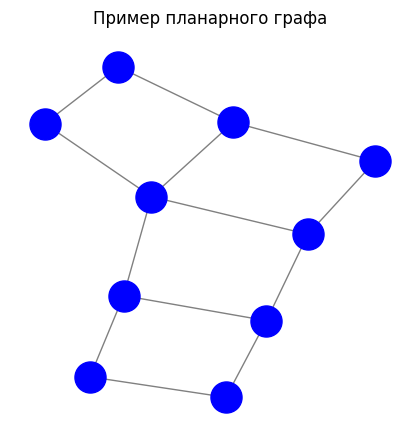

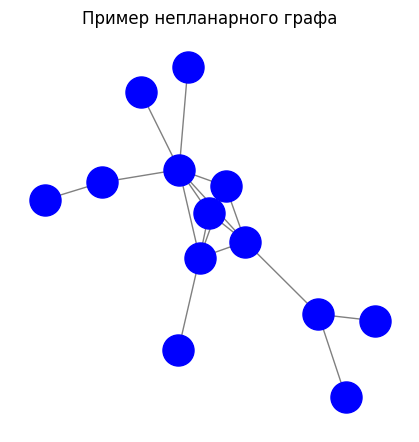

In [119]:
import matplotlib.pyplot as plt

def draw_graph(G, title):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(4, 4))
    nx.draw(G, pos, node_color='blue', edge_color='gray', node_size=500)
    plt.title(title)
    plt.show()


planar_iter = (graph for graph, label in zip(graphs, labels) if label == 0)
non_plannar_iter = (graph for graph, label in zip(graphs, labels) if label == 1)

graph = next(planar_iter)
non_plannar_graph = next(non_plannar_iter)

draw_graph(graph, title="Пример планарного графа")
draw_graph(non_plannar_graph, title="Пример непланарного графа")


## Shortest Path Kernel

In [120]:
import numpy as np
from collections import defaultdict

def shortest_path_kernel(train_graphs, test_graphs, max_paths = 10):
    def graph_to_vector(G, max_path_length):
        path_counts = defaultdict(int)
        nodes = sorted(G.nodes())
        lengths = dict(nx.shortest_path_length(G))

        for source in lengths:
          for target in lengths[source]:
            if source < target:
              d = lengths[source][target]
              if d <= max_path_length:
                path_counts[d] += 1

        return np.array([path_counts.get(l, 0) for l in range(1, max_path_length + 1)])

    train_vectors = np.array([graph_to_vector(G, max_paths) for G in train_graphs])
    test_vectors = np.array([graph_to_vector(G, max_paths) for G in test_graphs])

    K_train = train_vectors @ train_vectors.T
    K_test = test_vectors @ train_vectors.T

    return K_train, K_test


## Weisfeiler-Lehman Kernel

In [121]:
from collections import Counter

def wl_subtree_vector(G, h):
    labels = {v: str(G.nodes[v].get("label", G.degree(v))) for v in G.nodes}
    features = Counter(labels.values())

    for _ in range(h):
        new_labels = {}
        for v in G.nodes:
            neigh_labels = sorted(labels[u] for u in G.neighbors(v))
            new_label = labels[v] + "|" + "|".join(neigh_labels)
            new_labels[v] = new_label
        labels = new_labels
        features.update(labels.values())

    return features

def wl_kernel(train_graphs, test_graphs, h=3):
    train_features = [wl_subtree_vector(G, h) for G in train_graphs]
    test_features = [wl_subtree_vector(G, h) for G in test_graphs]

    vocab = {}
    for feats in train_features + test_features:
        for label in feats:
            if label not in vocab:
                vocab[label] = len(vocab)
    dim = len(vocab)

    def to_vector(feats):
        vec = np.zeros(dim, dtype=np.float32)
        for label, count in feats.items():
            vec[vocab[label]] = count
        return vec

    train_vectors = np.array([to_vector(f) for f in train_features])
    test_vectors = np.array([to_vector(f) for f in test_features])

    K_train = train_vectors @ train_vectors.T
    K_test = test_vectors @ train_vectors.T

    return K_train, K_test

## Обучение и подбор параметров

In [122]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


C_VALUES     = [0.05, 0.1, 1, 5, 10, 50]
GAMMA_VALUES = [0.001, 0.01, 0.1, 1, 10]

def create_and_fit_grid(param_grid, K_train, y_train):
    svm = SVC(kernel='precomputed', probability=True, random_state=SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    grid = GridSearchCV(
      estimator=svm,
      param_grid=param_grid,
      cv = cv,
      refit=True,
      verbose=0,
      return_train_score=False)

    grid.fit(K_train, y_train)
    return grid


def score_print(grid, K_test, y_test, title):
    print(f"\n{title}\n")
    print("Best score: ", grid.best_score_)
    print("Best param: ", grid.best_params_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(K_test)

    print("\nTest set performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))


K_short_train, K_short_test = shortest_path_kernel(X_train, X_test)

K_wl_train, K_wl_test = wl_kernel(X_train, X_test)

param_grid = {"gamma": GAMMA_VALUES, "C": C_VALUES, }


### Подбор гиперпараметров для Shortest Path Kernel

In [123]:
grid_short = create_and_fit_grid(param_grid, K_short_train, y_train)

score_print(grid_short, K_short_test, y_test, "Shortest Path Kernel results")


Shortest Path Kernel results

Best score:  0.82
Best param:  {'C': 5, 'gamma': 0.001}

Test set performance:
Accuracy: 0.77
Precision: 0.8947368421052632
Recall: 0.6415094339622641
F1 score: 0.7472527472527473


### Подбор гиперпараметров для Weisfeiler-Lehman Kernel

In [124]:
grid_short = create_and_fit_grid(param_grid, K_wl_train, y_train)

score_print(grid_short, K_wl_test, y_test, "Weisfeiler-Lehman Kernel results")


Weisfeiler-Lehman Kernel results

Best score:  0.9974999999999999
Best param:  {'C': 0.05, 'gamma': 0.001}

Test set performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


## Выводы

Weisfeiler-Lehman kernel демонстрирует высокую эффективность в задачах, где критически важна топологическая структура графов.

Благодаря итеративному учёту контекста окрестностей вершин, оно способно улавливать тонкие структурные различия между графами. Это особенно заметно при классификации планарных и непланарных графов, где такие характерно сложные структуры, как K_5 и K_{3, 3}, лучше распознаются по сравнению с более простыми методами, такими как Shortest Path Kernel.

Таким образом, Weisfeiler-Lehman kernel показывает явное преимущество в задачах, чувствительных к топологическим особенностям графа.